# Chapter 6 : Gated RNN

LSTM, GRU 등이 Gate가 추가된 RNN

[[ 1.78862847  0.43650985  0.09649747]
 [-1.8634927  -0.2773882  -0.35475898]
 [-0.08274148 -0.62700068 -0.04381817]]


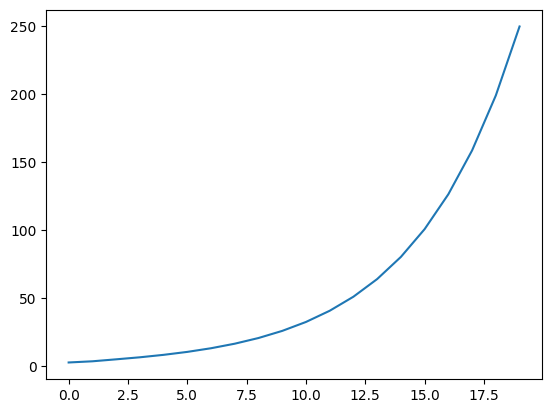

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)
print(Wh)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # 모든 행렬값을 제곱하고 더함
    norm_list.append(norm)

plt.plot(norm_list)

'''
기울기 폭주(폭발) 문제가 발생함.
vanishing gradient는 설명 생략
'''

Exploding gradient 해결하기 위해 gradient clipping 사용

tcp congestion control과 같이 일정 threshold 값보다 높으면 (threshold) / ||gradient|| 를 곱함

In [5]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10

grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm = np.sum(grad**2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    # max_norm 보다 total_norm이 높을 경우
    if rate < 1:
        for gead in grads:
            grad *= rate

LSTM에선 RNN에서 memory cell이라는 계층이 하나 더 등장함

Ct (memory cell) 기억하기 위한 셀이며 LSTM 계층으로만 연결되고 출력 X

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        a = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        f = a[: , :H]
        g = a[: , H:2*H]
        i = a[:, 2*H : 3*H]
        o = a[:, 3*H : ]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

In [8]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h , self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, : ] = self.h

            self.layers.append(layer)
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        grads = [0, 0, 0]

        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i,grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs 

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None   

RNNLM (TimeLSTM)

In [15]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(D, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')


        self.layers = [TimeEmbedding(embed_W),
                       TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                       TimeAffine(affine_W, affine_b)]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs):
            for layer in self.layers:
                xs = layer.forward(xs)
            return xs
        
    def forward(self, xs, ts):
            score = self.predict(xs)
            loss = self.loss_layer.forward(score, ts)
            return loss
        
    def backward(self, dout = 1):
            dout = self.loss_layer.backward(dout)
            for layer in self.layers:
                dout = layer.backward(dout)
            return dout

    def reset_state(self):
            self.lstm_layer.reset_state()
        
    def save_params(self, file_name = 'Rnnlm.pkl'):
            with open(file_name, 'wb') as f:
                pickle.dump(self.params, f)
        
    def load_params(self, file_name='Rnn.pkl'):
            with open(file_name, 'rb') as f:
                self.params = pickle.load(f)

In [ ]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print("perplexity : ", ppl_test)

model.save_params()

Dropout이 추가된 RNN

In [3]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(H).astype('f')

        self.layers = [TimeEmbedding(embed_W),
                       TimeDropout(dropout_ratio),
                       TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1),
                       TimeDropout(dropout_ratio),
                       TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2),
                       TimeDropout(dropout_ratio),
                       TimeAffine(embed_W, affine_b)]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import sys
sys.path.append('..')
from common import config
config.GPU = True
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print("validate perplexity :", ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
    
    model.reset_state()
    print('-' * 50)